<a href="https://colab.research.google.com/github/GAOYUEtianc/DNA_discriminator/blob/main/DNA_Discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
# Read the DNA sequences from csv
import pandas as pd 
Trainsequence = pd.read_csv('/content/gdrive/My Drive/train.csv')
print(Trainsequence.shape)

(7499, 1)


In [43]:
import numpy as np
import random
import string
# Convert each DNA sequence into a one-hot matrix
n = Trainsequence.shape[0]
X_train = np.zeros((n, 100, 4)) # For each sequence (of length at most 100, there're 4 possible bases)
mapping = dict(zip("ACGT", range(4)))
for i in range(0,n):
    seq = [mapping[j] for j in Trainsequence.iloc[i][0]]
    X_train[i,:len(Trainsequence.iloc[i][0]),:] = np.eye(4)[seq]
y_train = np.ones((n, 1))
# Get Reverse DNA sequence 
X_train_inverse = np.zeros((n, 100, 4))
correspond = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
for i in range(0,n):
    reverse_string = "".join(correspond[base] for base in reversed(Trainsequence.iloc[i][0]))
    seq = [mapping[j] for j in reverse_string]
    X_train_inverse[i,:len(Trainsequence.iloc[i][0]),:] = np.eye(4)[seq]
y_train_inverse = np.zeros((n, 1))

# Get negative sequence by shuffling the positive ones
X_nega = np.zeros(X_train.shape)
for i in range(0,n):
    seq_i = Trainsequence.iloc[i][0]
    shuffle_seq = ''.join(random.sample(seq_i, len(seq_i)))
    seq = [mapping[j] for j in shuffle_seq]
    X_nega[i,:len(shuffle_seq),:] = np.eye(4)[seq]
y_train_nega = np.zeros((n, 1))

In [44]:
from keras.models import Model
from keras import Input
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from keras.layers import Flatten, LeakyReLU, Dropout, Reshape, Conv2DTranspose, Embedding, LSTM, Dense, BatchNormalization, Concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D


In [45]:
input_layer = Input(shape=(100,4,1))

# Convolutional Layer extracting features from data
kernel_size = (5,5)
strides_size = (3,3)
# First Layer CNN
x = Conv2D(128, kernel_size, padding = "same", strides = strides_size)(input_layer)
x = LeakyReLU(alpha = 0.2)(x)
# Second layer CNN
x = Conv2D(128, kernel_size, padding = "same", strides = strides_size)(x)
x_conv = LeakyReLU(alpha = 0.2)(x)
# Max pooling , then flatten
x_output_1 = MaxPooling2D(pool_size = (3,3),padding='same')(x_conv)
x_output_1 = Flatten()(x_output_1)
# Average pooling , then flatten
x_output_2 = AveragePooling2D(pool_size = (3,3),padding='same')(x_conv)
x_output_2 = Flatten()(x_output_2)

# Concatenate the output of MaxPooling and Average Pooling 
output = Concatenate(axis = 1)((x_output_1, x_output_2))

# Do batch normalization
output = BatchNormalization(epsilon=1e-06, momentum=0.95)(output, training=True)
# Add a fully connected layer 
output = Dense(50, activation='relu')(output)
# Dropout features to prevent overfitting
output = Dropout(0.5)(output)
# Add another fully connected layer
output = Dense(1, activation='sigmoid')(output)
Discriminator_Model = Model(input_layer, output)
Discriminator_Model.compile(loss = 'binary_crossentropy', metrics='accuracy')

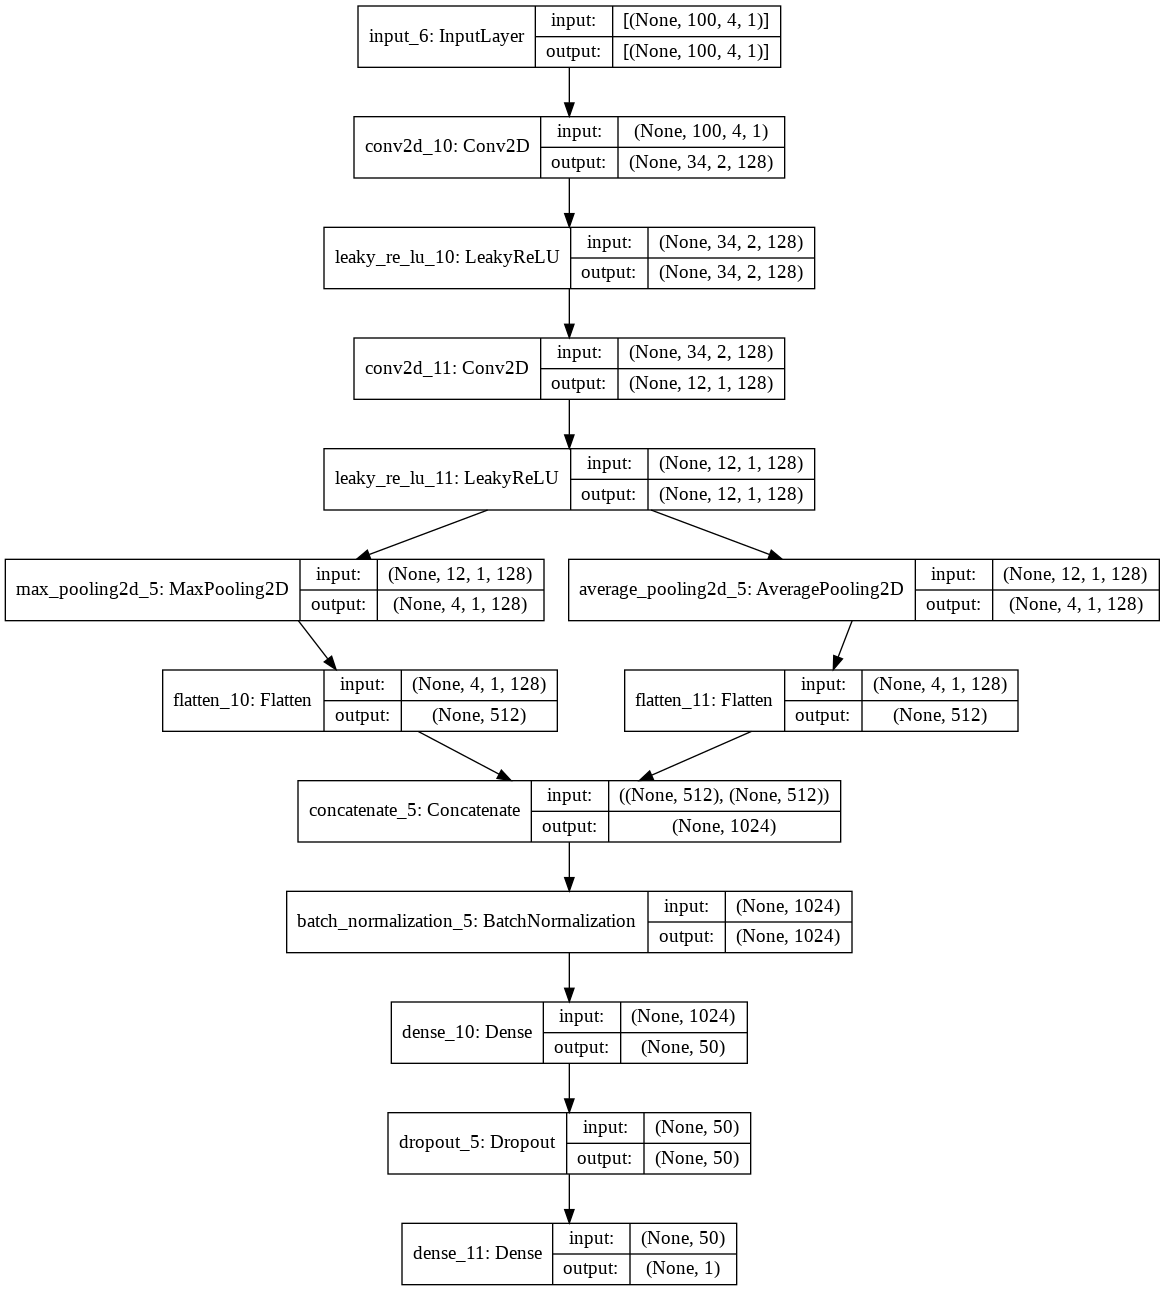

In [46]:
# Plot the model
from keras.utils.vis_utils import plot_model
plot_model(Discriminator_Model,show_shapes=True)

In [47]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
path = F"/content/gdrive/My Drive/DNA_Discriminator.hdf5"
checkpointer = ModelCheckpoint(filepath=path, verbose=1, save_best_only=False)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


In [48]:
# Combine the Training dataset (Using Inverse Seq as the negative data) and shuffle it
X = np.vstack((X_train, X_train_inverse))
y = np.vstack((y_train, y_train_inverse))
print(X.shape)
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
y = y[randomize]

(14998, 100, 4)


In [49]:
n_train = int(0.7*n)
X_Train = X[:n_train]
y_Train = y[:n_train]
X_Valid_1 = X[n_train:int(0.8*n)]
y_Valid_1 = y[n_train:int(0.8*n)]
X_Test_1 = X[int(0.8*n):]
y_Test_1 = y[int(0.8*n):]
Discriminator_Model.fit(X_Train, y_Train, batch_size=100, epochs=30, shuffle=True, verbose=1, validation_data=(X_Valid_1, y_Valid_1), callbacks=[checkpointer,earlystopper])
Discriminator_Model.save(path)

Epoch 1/30
53/53 [==============================] - 10s 165ms/step - loss: 0.4849 - accuracy: 0.7832 - val_loss: 0.1836 - val_accuracy: 0.9360

Epoch 00001: saving model to /content/gdrive/My Drive/DNA_Discriminator.hdf5
Epoch 2/30
53/53 [==============================] - 9s 162ms/step - loss: 0.1561 - accuracy: 0.9394 - val_loss: 0.1187 - val_accuracy: 0.9547

Epoch 00002: saving model to /content/gdrive/My Drive/DNA_Discriminator.hdf5
Epoch 3/30
53/53 [==============================] - 9s 161ms/step - loss: 0.0866 - accuracy: 0.9707 - val_loss: 0.0902 - val_accuracy: 0.9667

Epoch 00003: saving model to /content/gdrive/My Drive/DNA_Discriminator.hdf5
Epoch 4/30
53/53 [==============================] - 8s 160ms/step - loss: 0.0625 - accuracy: 0.9773 - val_loss: 0.1022 - val_accuracy: 0.9640

Epoch 00004: saving model to /content/gdrive/My Drive/DNA_Discriminator.hdf5
Epoch 5/30
53/53 [==============================] - 9s 162ms/step - loss: 0.0413 - accuracy: 0.9853 - val_loss: 0.0894 

In [50]:
# Combine the Training dataset (Using Random Suffled Seq as the negative data) and shuffle it
X = np.vstack((X_train, X_nega))
y = np.vstack((y_train, y_train_nega))
print(X.shape)
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
y = y[randomize]

(14998, 100, 4)


In [57]:
# Train the 2nd model using the shuffled data
input_layer = Input(shape=(100,4,1))

# Convolutional Layer extracting features from data
kernel_size = (5,5)
strides_size = (3,3)
# First Layer CNN
x = Conv2D(128, kernel_size, padding = "same", strides = strides_size)(input_layer)
x = LeakyReLU(alpha = 0.2)(x)
# Second layer CNN
x = Conv2D(128, kernel_size, padding = "same", strides = strides_size)(x)
x_conv = LeakyReLU(alpha = 0.2)(x)
# Max pooling , then flatten
x_output_1 = MaxPooling2D(pool_size = (3,3),padding='same')(x_conv)
x_output_1 = Flatten()(x_output_1)
# Average pooling , then flatten
x_output_2 = AveragePooling2D(pool_size = (3,3),padding='same')(x_conv)
x_output_2 = Flatten()(x_output_2)

# Concatenate the output of MaxPooling and Average Pooling 
output = Concatenate(axis = 1)((x_output_1, x_output_2))

# Do batch normalization
output = BatchNormalization(epsilon=1e-06, momentum=0.95)(output, training=True)
# Add a fully connected layer 
output = Dense(50, activation='relu')(output)
# Dropout features to prevent overfitting
output = Dropout(0.5)(output)
# Add another fully connected layer
output = Dense(1, activation='sigmoid')(output)
Discriminator_Model_2 = Model(input_layer, output)
Discriminator_Model_2.compile(loss = 'binary_crossentropy', metrics='accuracy')

from keras.callbacks import ModelCheckpoint, EarlyStopping
path = F"/content/gdrive/My Drive/DNA_Discriminator_Shuffle.hdf5"
checkpointer = ModelCheckpoint(filepath=path, verbose=1, save_best_only=False)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
n_train = int(0.7*n)
X_Train = X[:n_train]
y_Train = y[:n_train]
X_Valid_2 = X[n_train:int(0.8*n)]
y_Valid_2 = y[n_train:int(0.8*n)]
X_Test_2 = X[int(0.8*n):]
y_Test_2 = y[int(0.8*n):]
Discriminator_Model_2.fit(X_Train, y_Train, batch_size=100, epochs=30, shuffle=True, verbose=1, validation_data=(X_Valid_2, y_Valid_2), callbacks=[checkpointer,earlystopper])
Discriminator_Model_2.save(path)


Epoch 1/30
53/53 [==============================] - 10s 164ms/step - loss: 0.5440 - accuracy: 0.7390 - val_loss: 0.2722 - val_accuracy: 0.8880

Epoch 00001: saving model to /content/gdrive/My Drive/DNA_Discriminator_Shuffle.hdf5
Epoch 2/30
53/53 [==============================] - 9s 162ms/step - loss: 0.2201 - accuracy: 0.9126 - val_loss: 0.2377 - val_accuracy: 0.9080

Epoch 00002: saving model to /content/gdrive/My Drive/DNA_Discriminator_Shuffle.hdf5
Epoch 3/30
53/53 [==============================] - 8s 160ms/step - loss: 0.1370 - accuracy: 0.9476 - val_loss: 0.1945 - val_accuracy: 0.9333

Epoch 00003: saving model to /content/gdrive/My Drive/DNA_Discriminator_Shuffle.hdf5
Epoch 4/30
53/53 [==============================] - 9s 161ms/step - loss: 0.0983 - accuracy: 0.9651 - val_loss: 0.1898 - val_accuracy: 0.9307

Epoch 00004: saving model to /content/gdrive/My Drive/DNA_Discriminator_Shuffle.hdf5
Epoch 5/30
53/53 [==============================] - 9s 162ms/step - loss: 0.0732 - accu

(8999, 1)
AUC for discriminator_1 (use reverse seq as training data) : 0.9974716519752282
AUPRC for discriminator_1 (use reverse seq as training data) : 0.9969795320210505


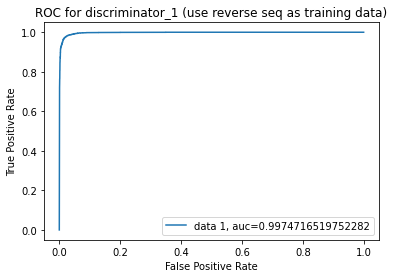

In [52]:
# Evaluate the Model 1
from sklearn.metrics import roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt
pred = Discriminator_Model.predict(X_Test_1)
print(pred.shape)
fpr, tpr, thresholds = roc_curve(y_Test_1, pred)
AUC = auc(fpr, tpr)
AUPRC = average_precision_score(y_Test_1, pred)
print("AUC for discriminator_1 (use reverse seq as training data) :", AUC)
print("AUPRC for discriminator_1 (use reverse seq as training data) :", AUPRC)
plt.plot(fpr,tpr,label="data 1, auc="+str(AUC))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for discriminator_1 (use reverse seq as training data)")
plt.legend(loc=4)
plt.show()

(8999, 1)
AUC for discriminator_2 (use shuffled seq as training data) : 0.9941483229055212
AUPRC for discriminator_2 (use shuffled seq as training data) : 0.9926803766208154


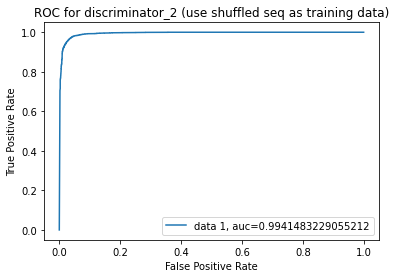

In [58]:
# Evaluate the Model 2
from sklearn.metrics import roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt
pred = Discriminator_Model_2.predict(X_Test_2)
print(pred.shape)
fpr, tpr, thresholds = roc_curve(y_Test_2, pred)
AUC = auc(fpr, tpr)
AUPRC = average_precision_score(y_Test_2, pred)
print("AUC for discriminator_2 (use shuffled seq as training data) :", AUC)
print("AUPRC for discriminator_2 (use shuffled seq as training data) :", AUPRC)
plt.plot(fpr,tpr,label="data 1, auc="+str(AUC))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for discriminator_2 (use shuffled seq as training data)")
plt.legend(loc=4)
plt.show()

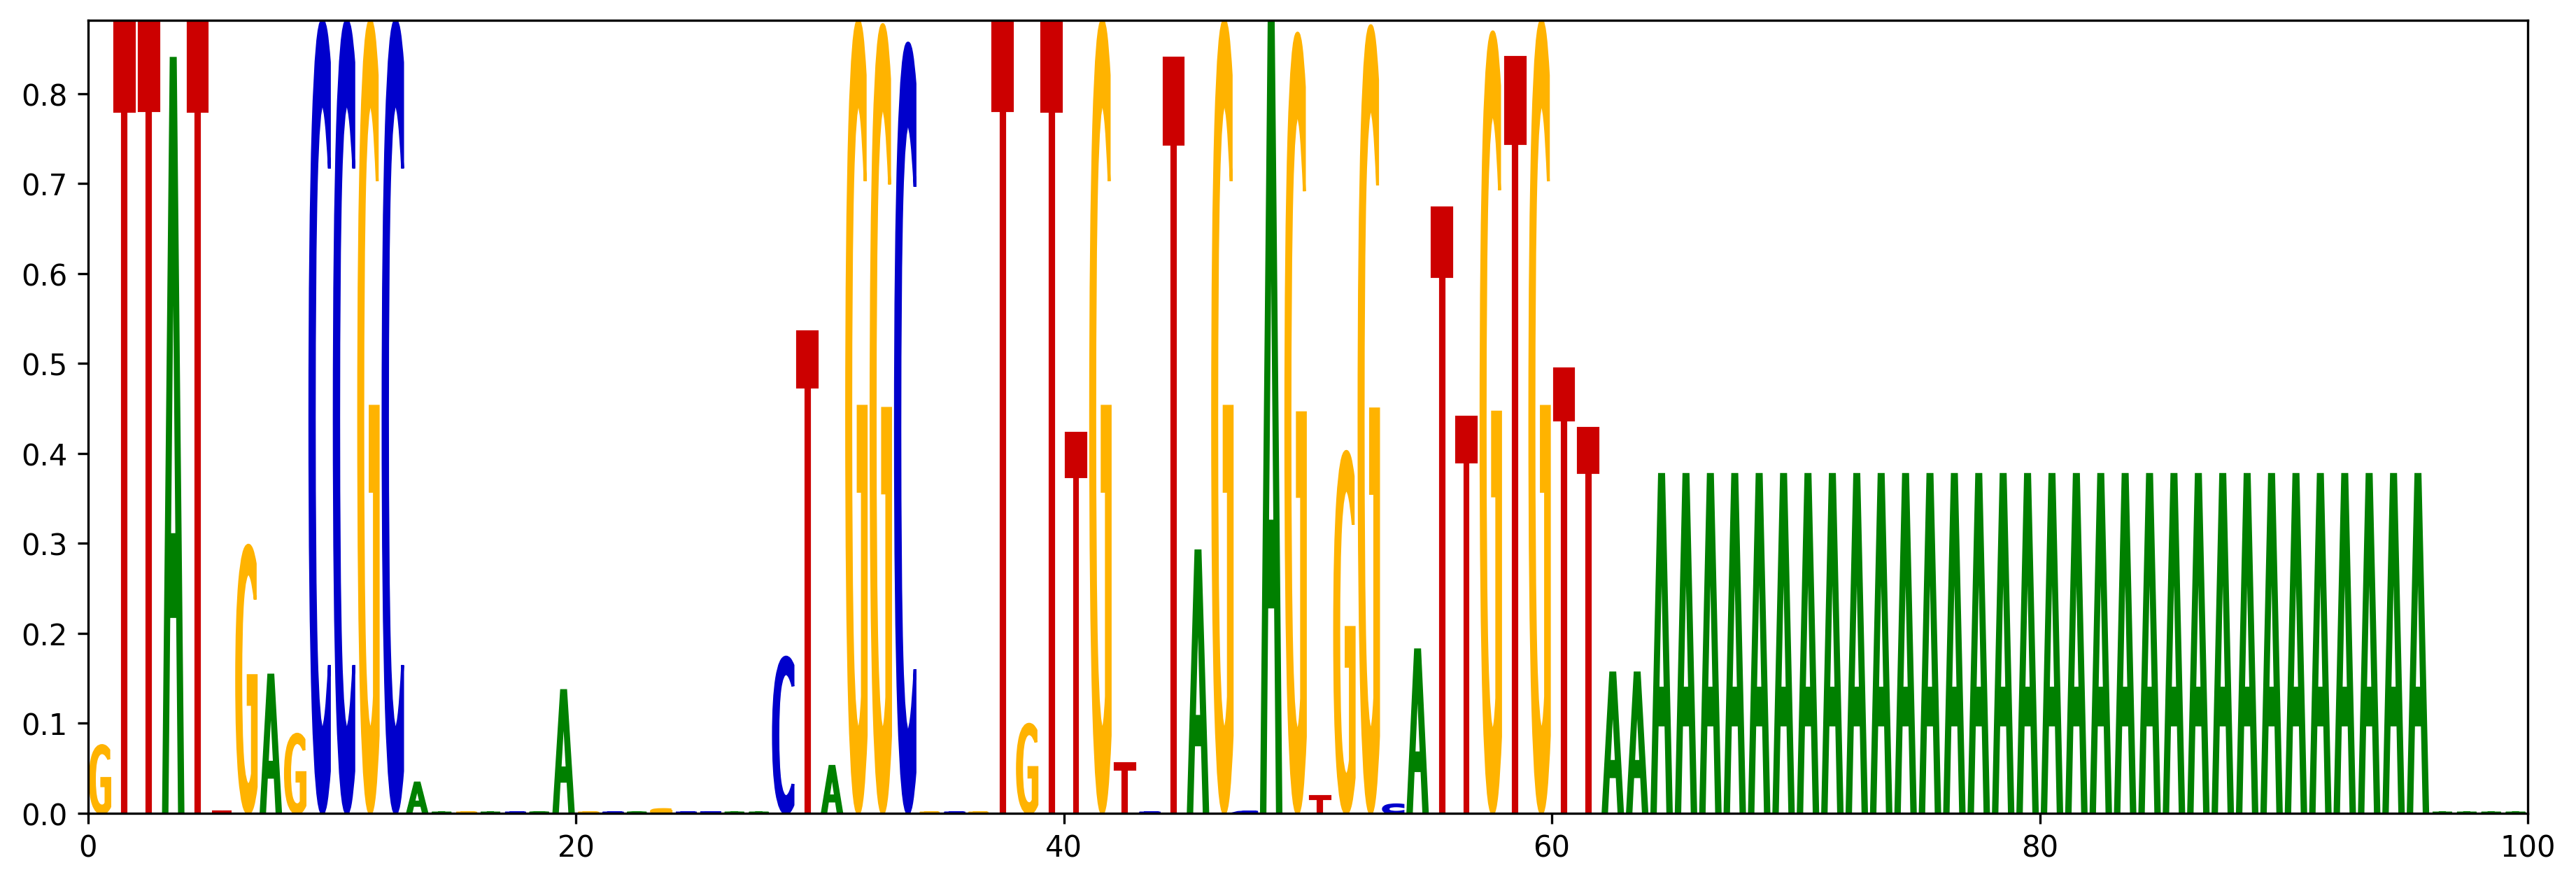

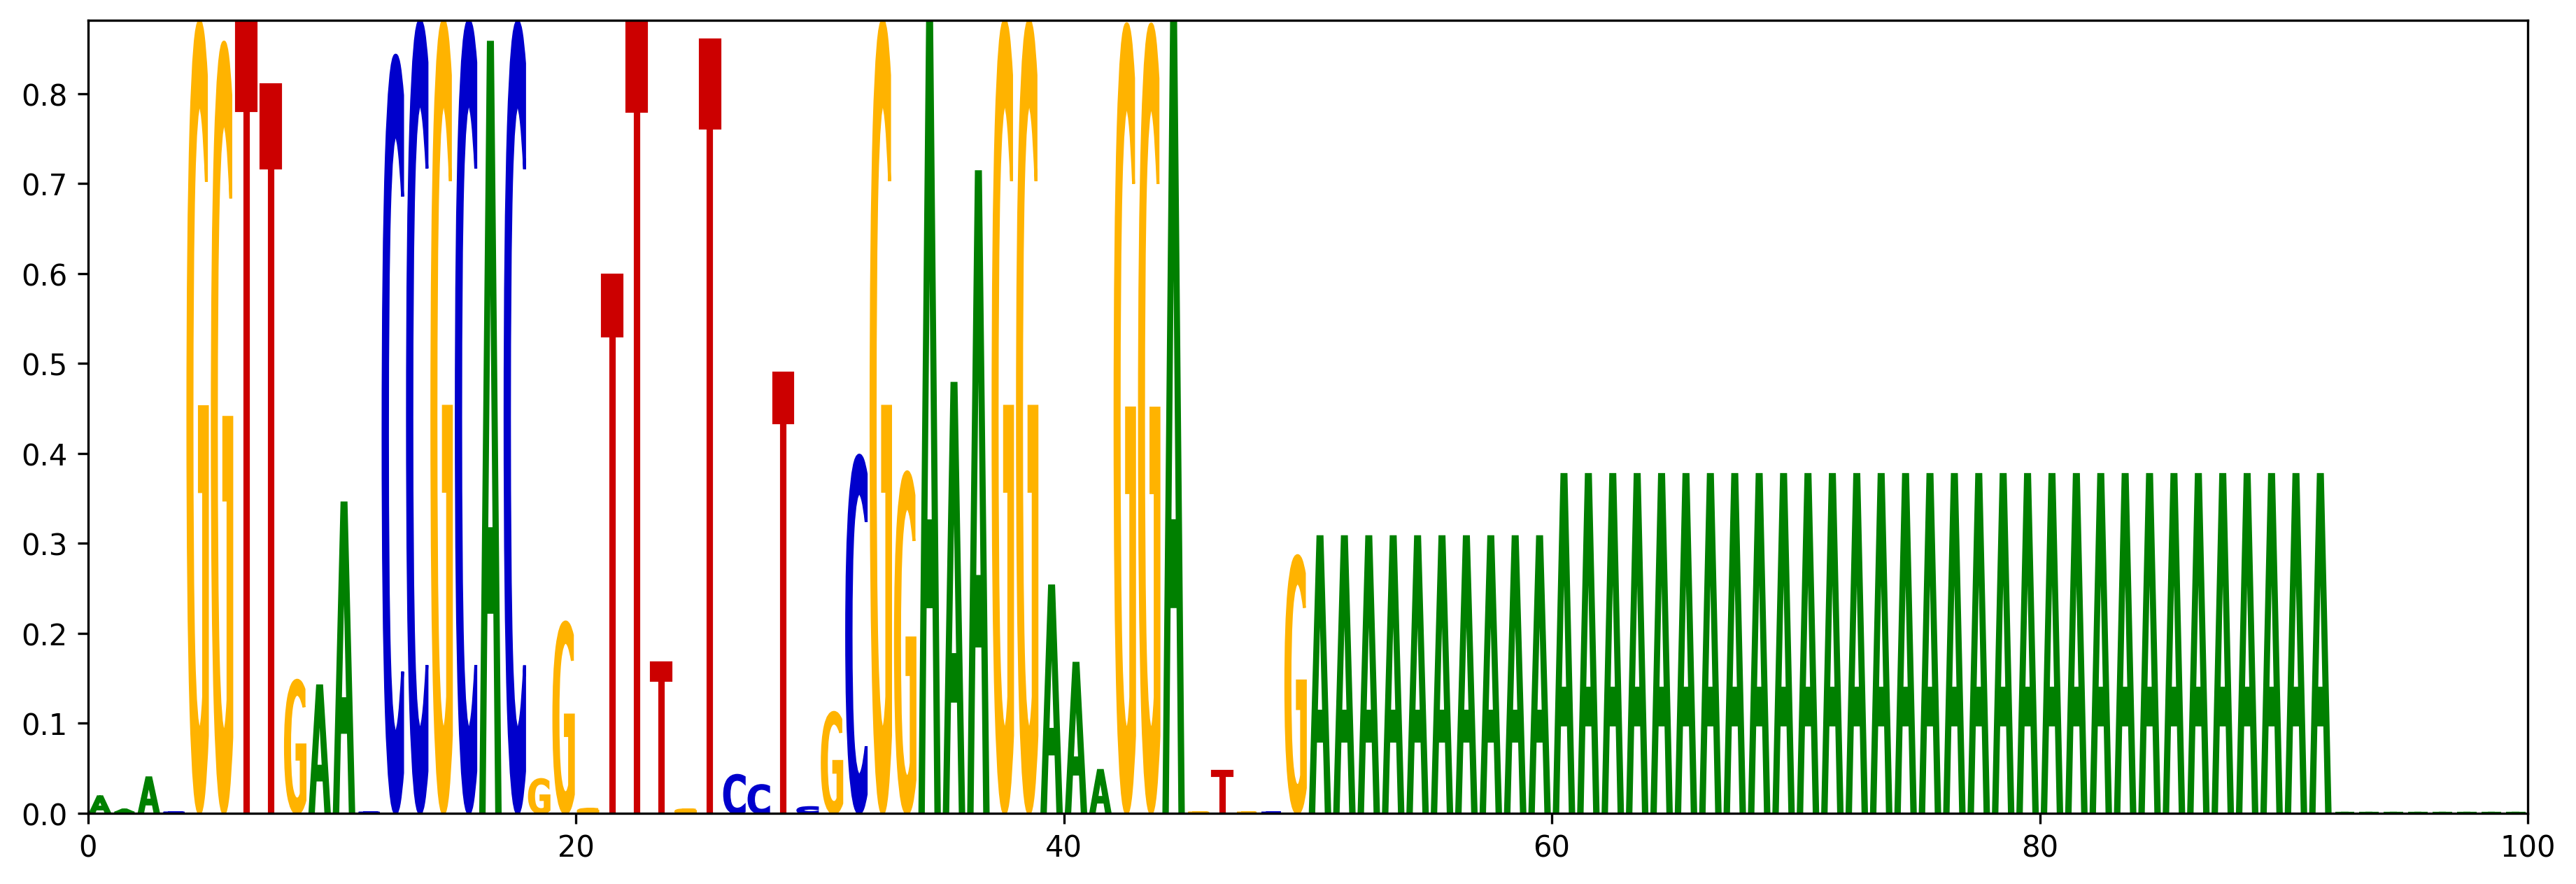

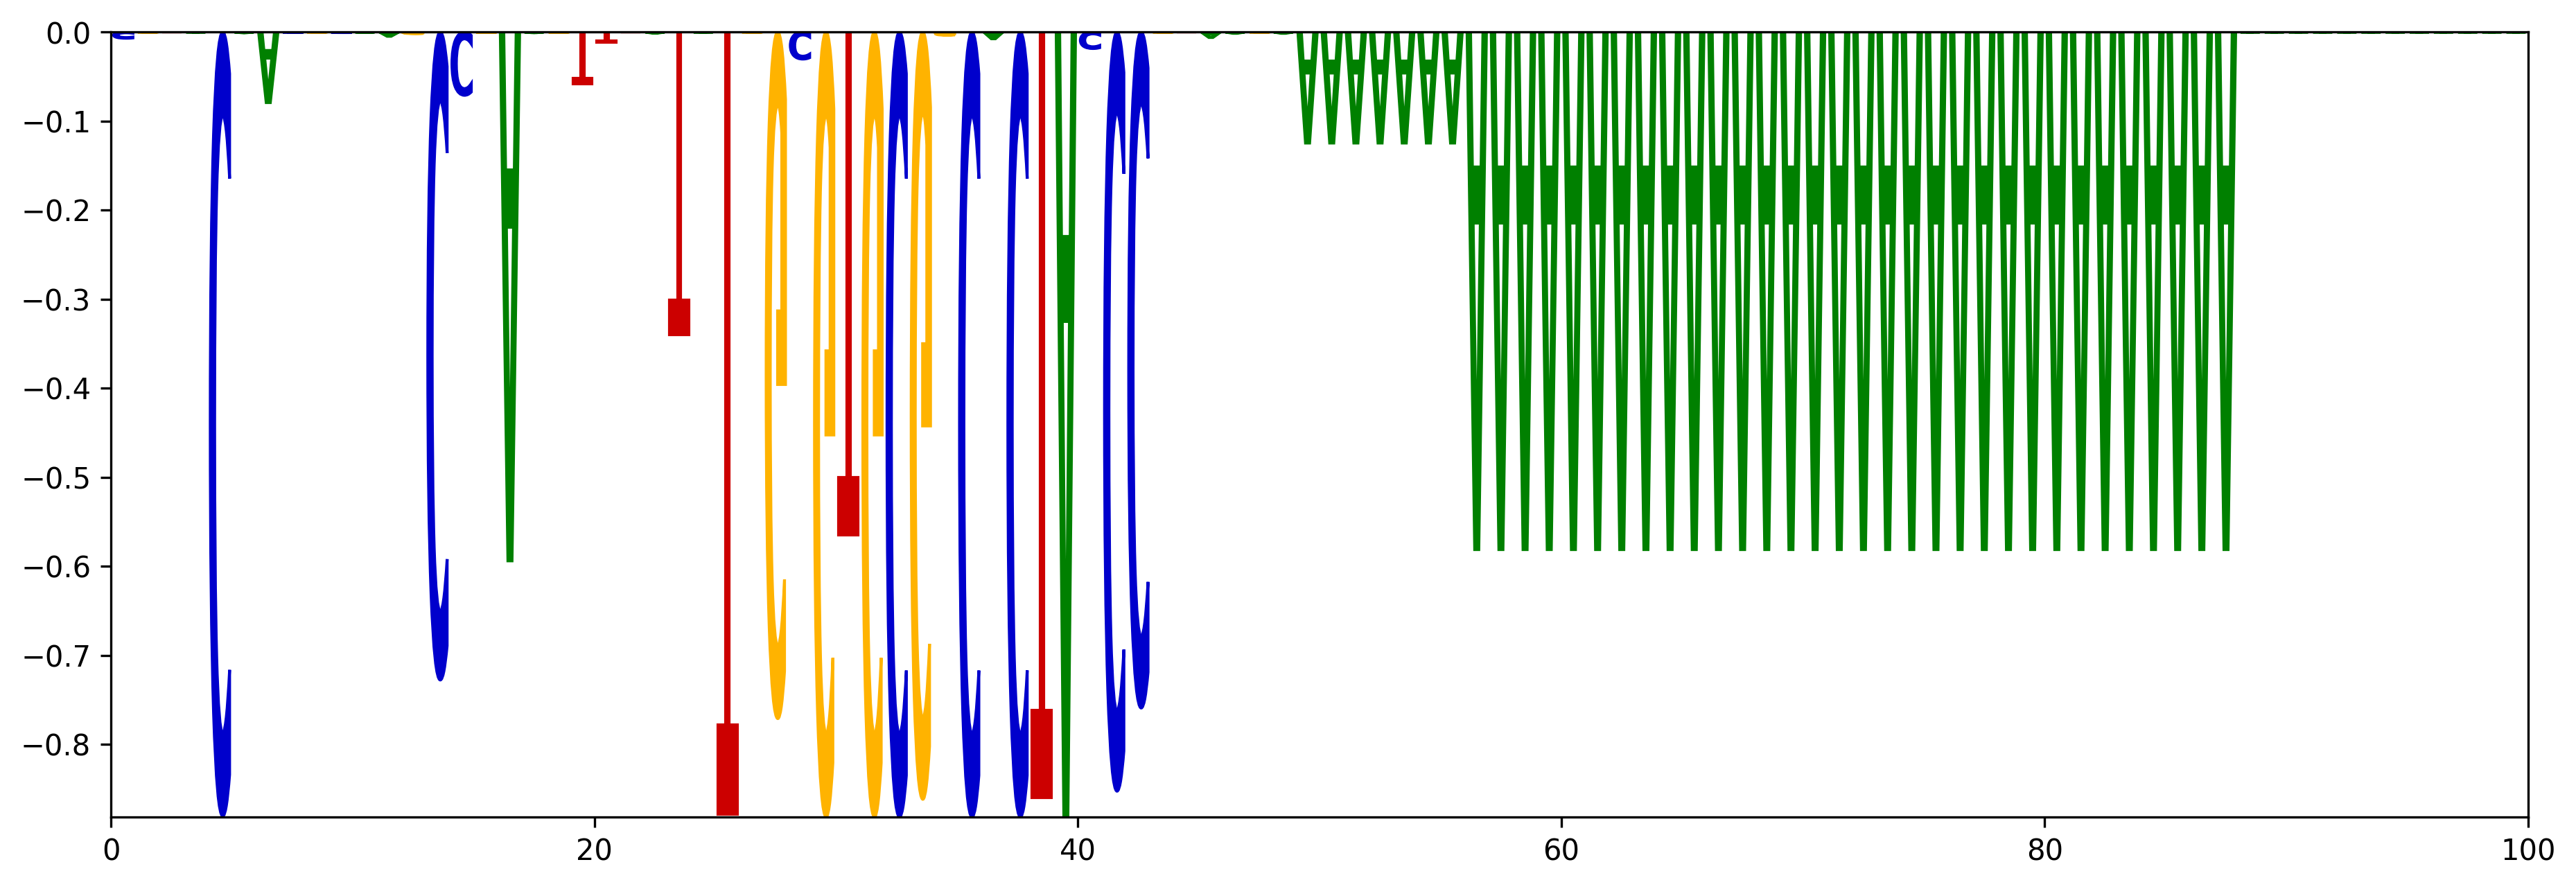

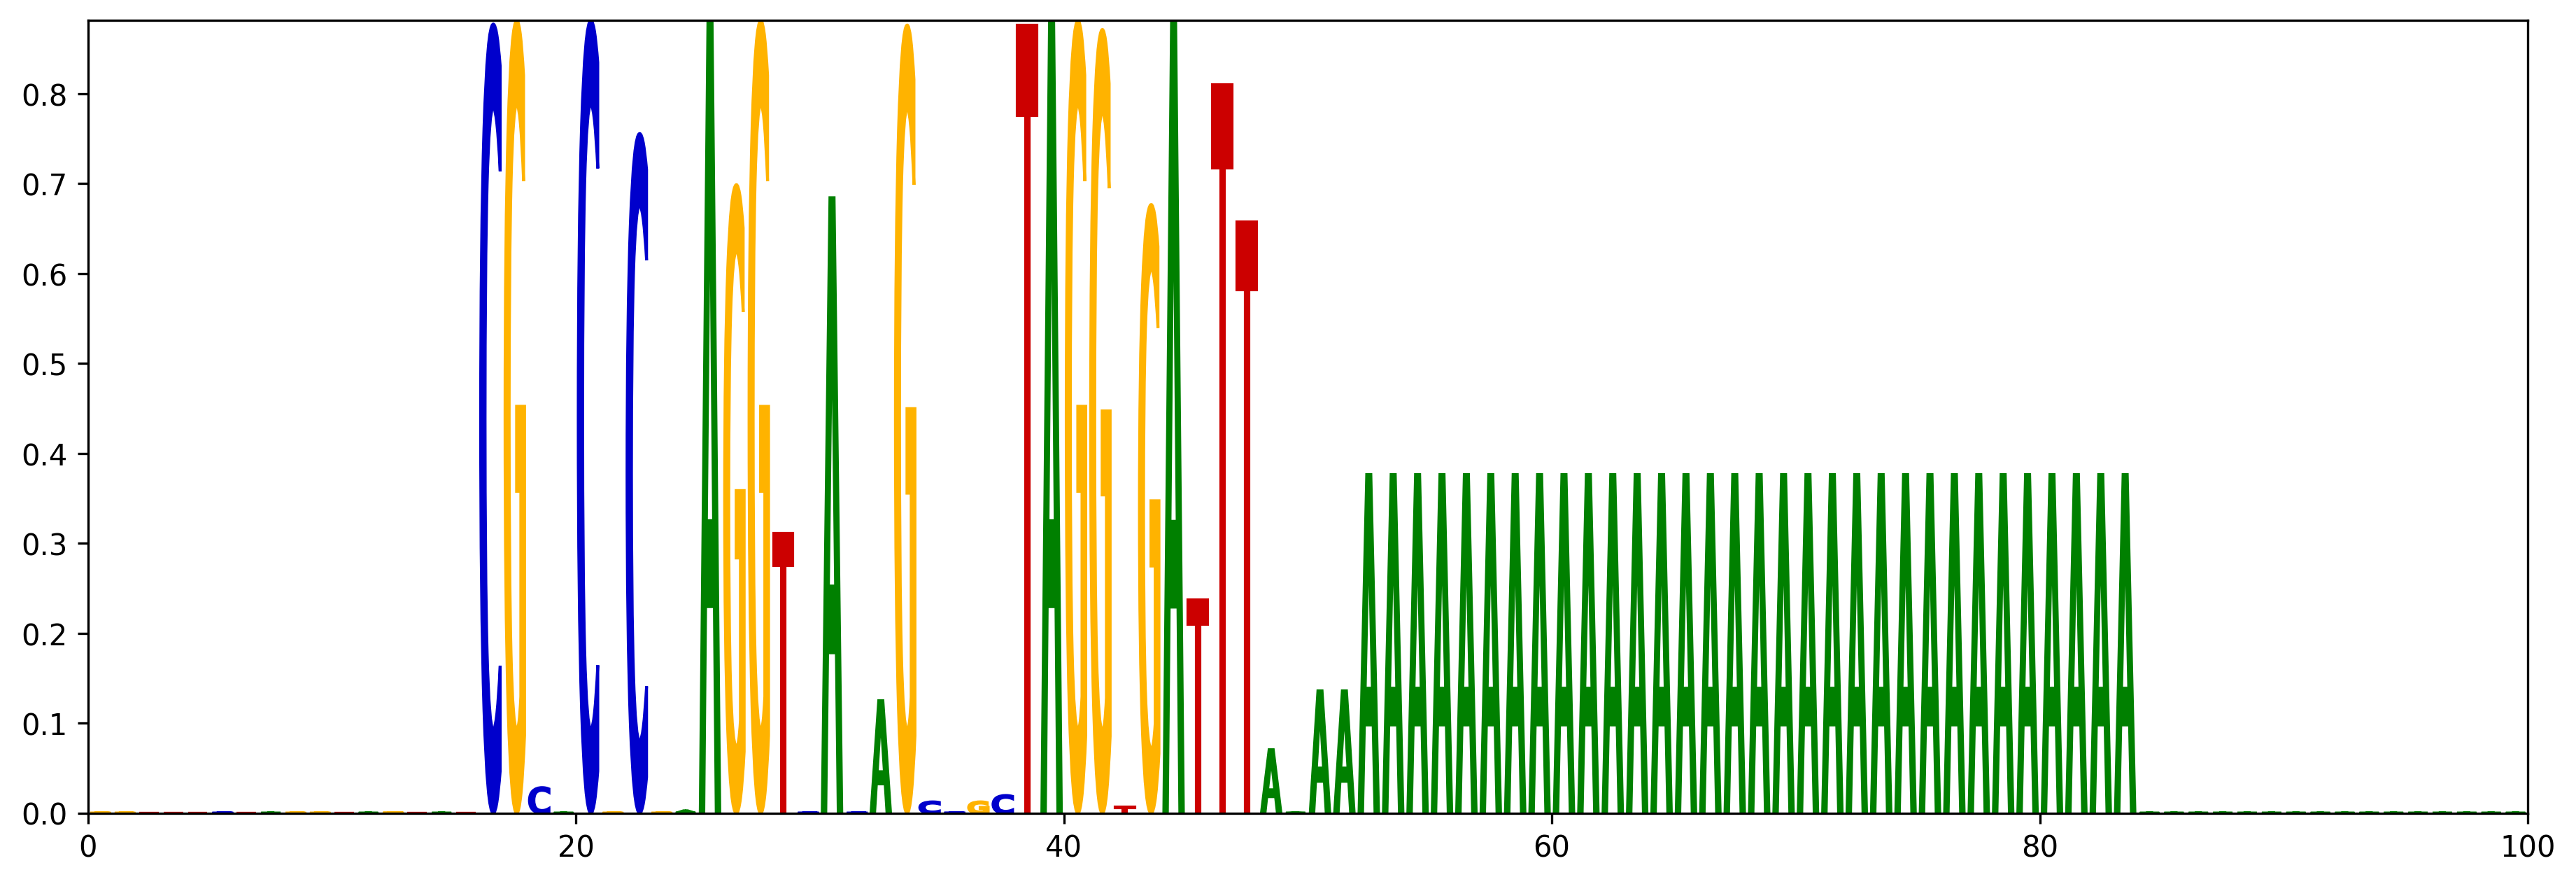

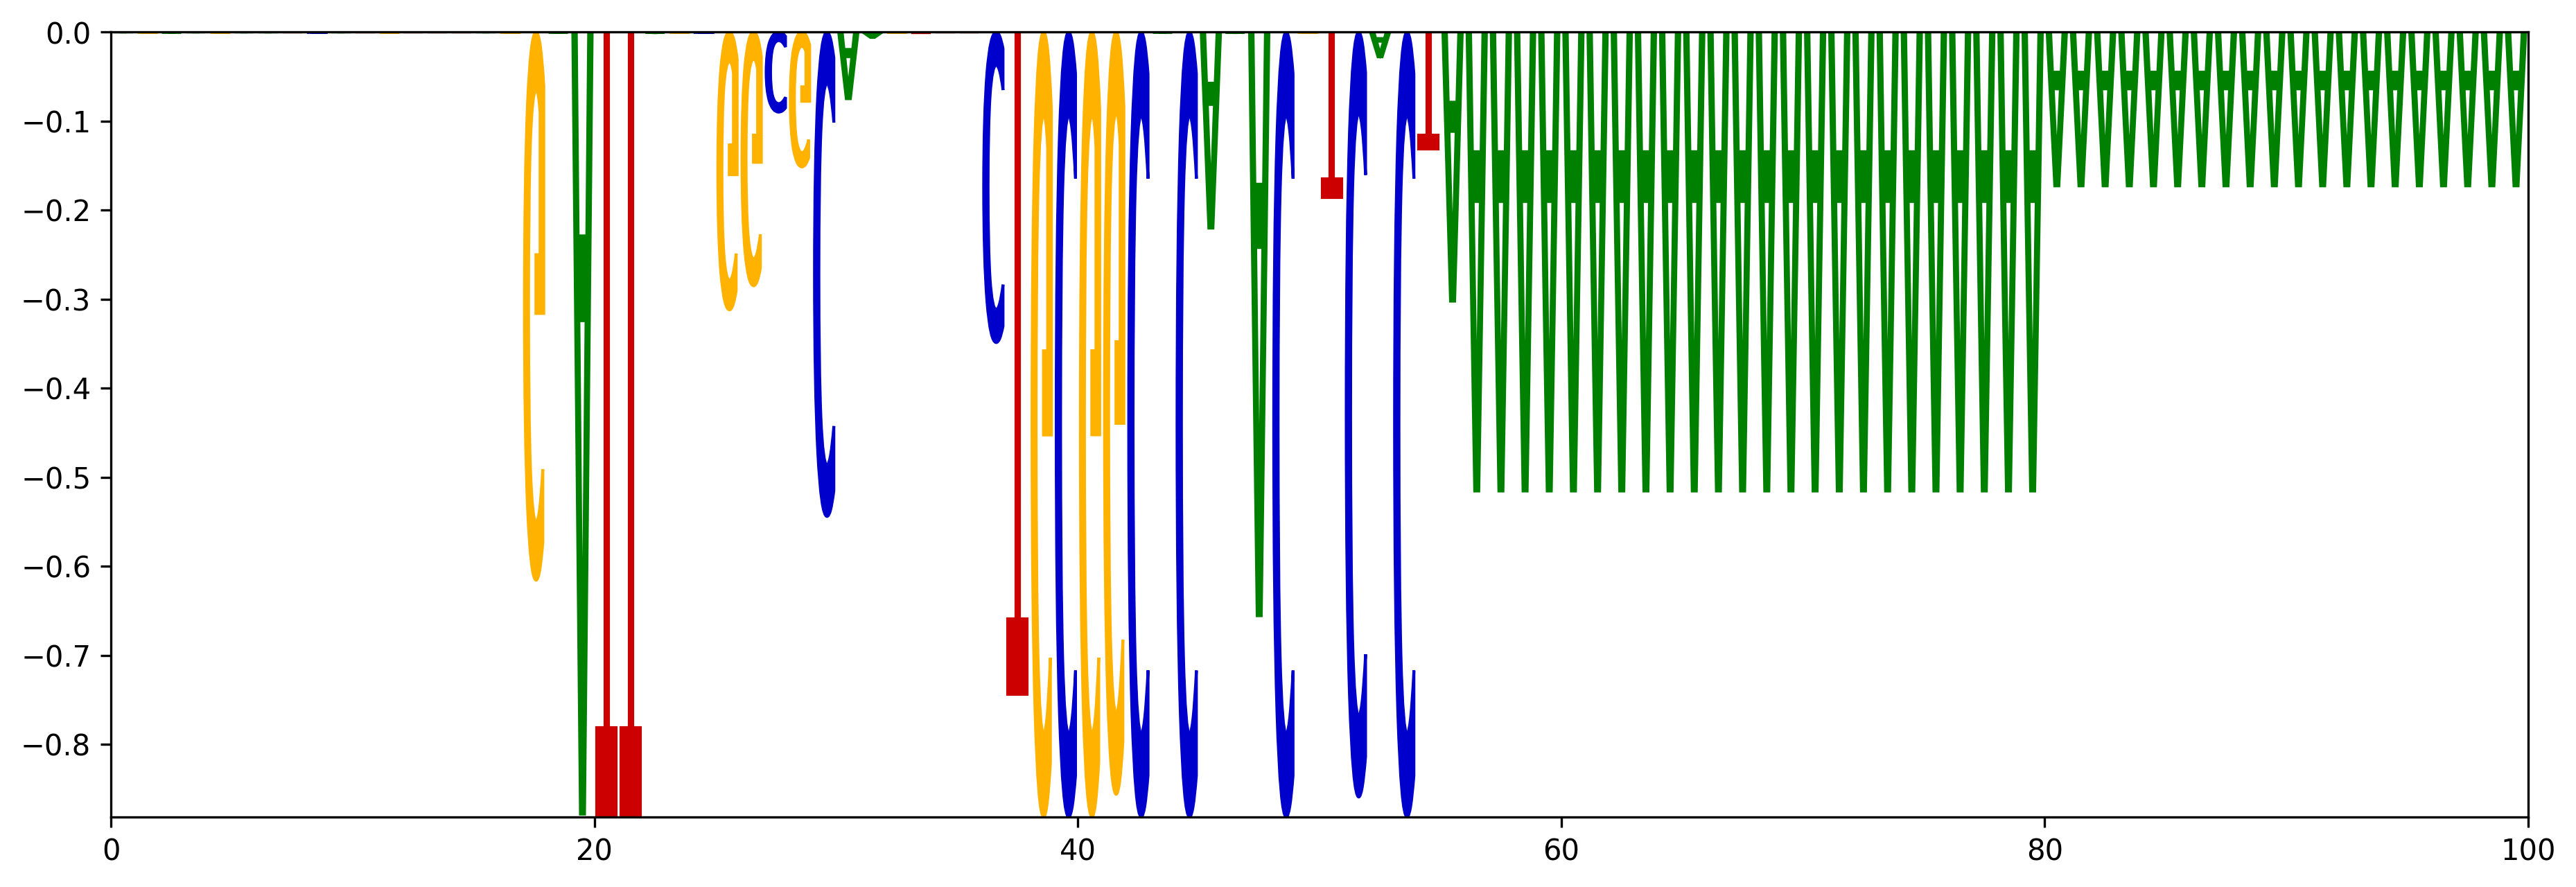

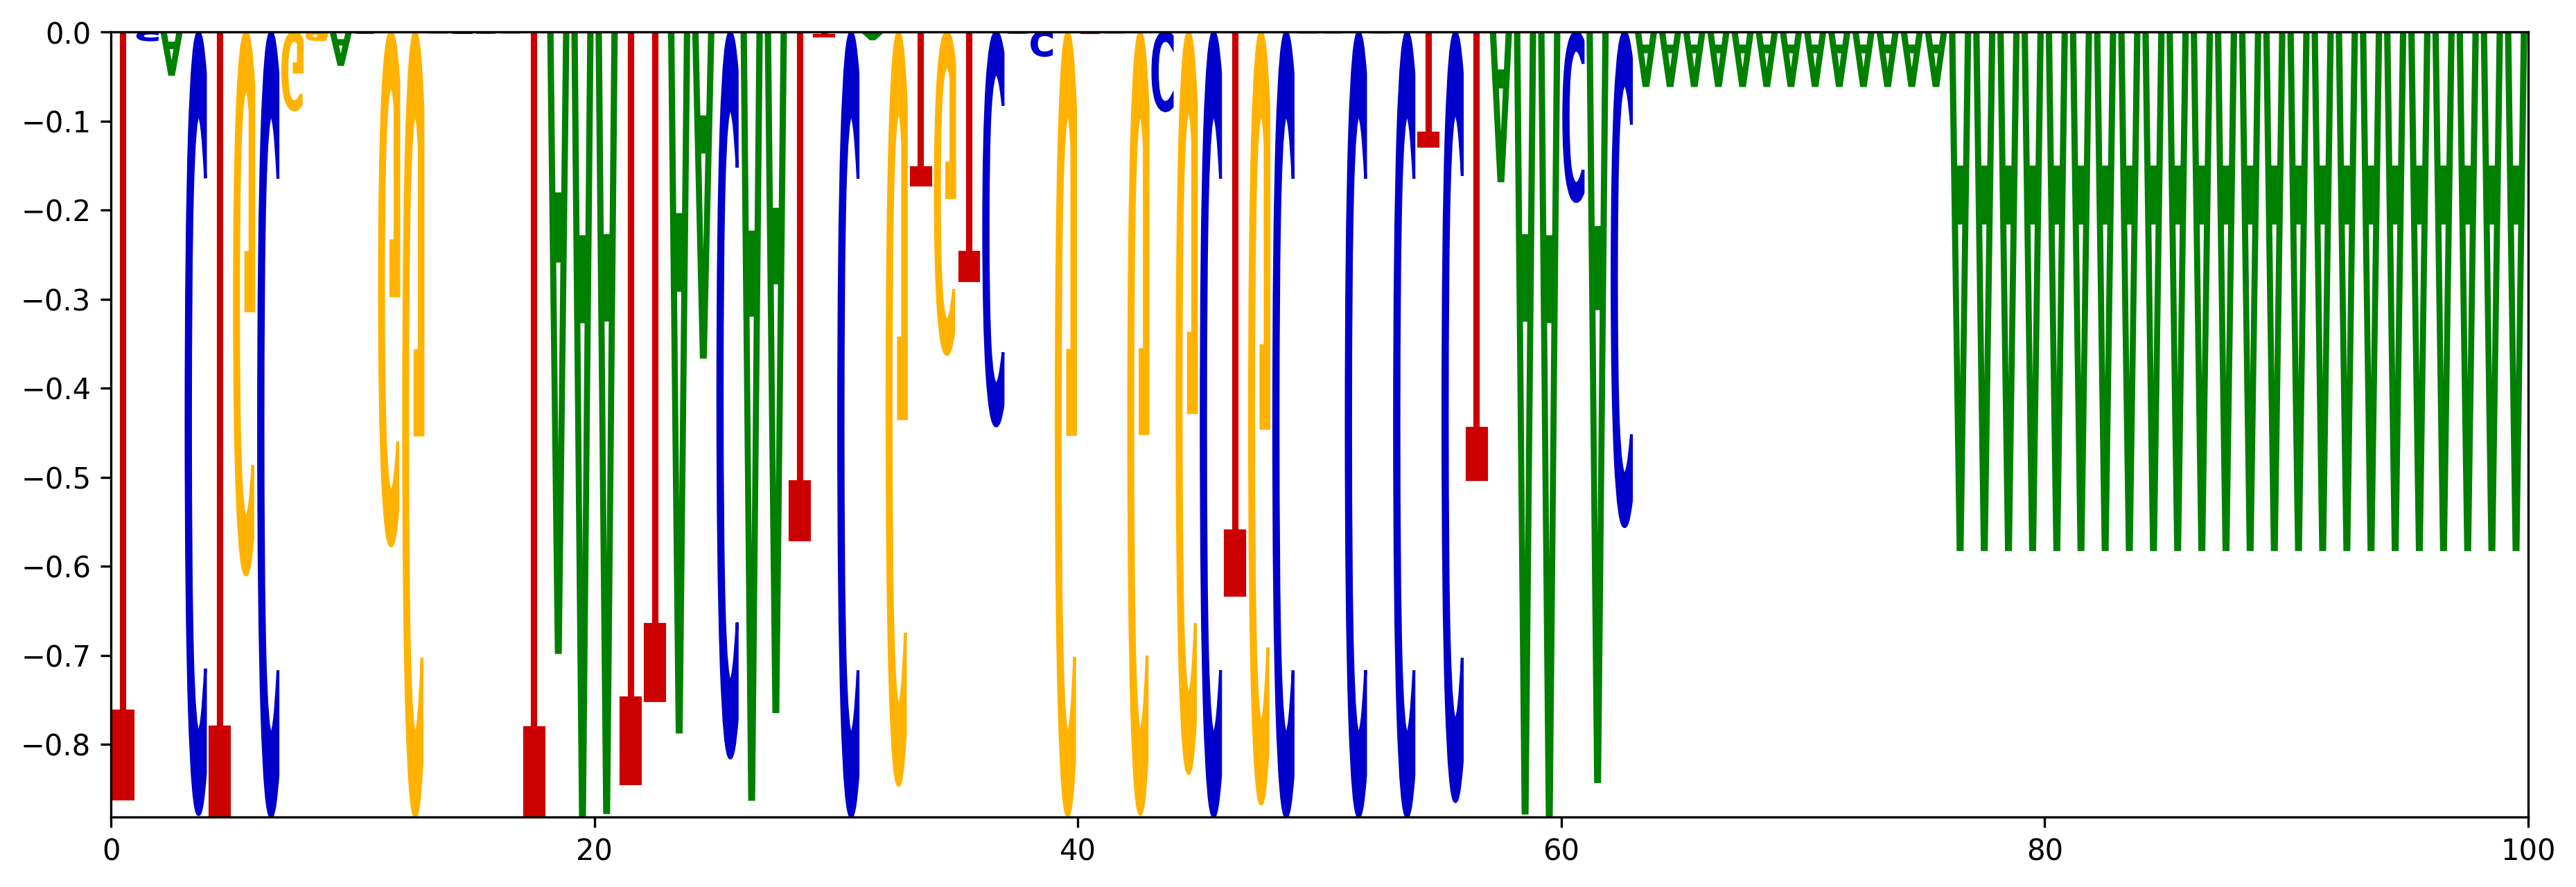

In [61]:
# Plot the 'ChIP-seq' for randomly 6 sequences for Model 1
index = np.random.randint(int(0.2*n), size=6)
sequencePlot = X_Test_1[index,:]
sequencePredict = Discriminator_Model.predict(sequencePlot).flatten()

# Generate a new set of X, where for each sequence every nucleotide is consecutively set to 0
sequencePlot = sequencePlot.reshape(sequencePlot.shape[0],sequencePlot.shape[1],sequencePlot.shape[2],1)
sequenceRepeat = np.repeat(sequencePlot, 100, axis=0)
# Generate sequence with one deleted nucleotide
a = np.ones((100, 100), int)
np.fill_diagonal(a, 0)
b = np.repeat(a.reshape((1,100,100)), sequencePlot.shape[0], axis=0)
c = np.concatenate(b, axis=0)
d = np.multiply(sequenceRepeat, np.repeat(c.reshape((sequenceRepeat.shape[0], 100, 1, 1)), 4, axis=2))

#Calculate the prediction for each sequence with one deleted nucleotide
d_pred = Discriminator_Model.predict(d.reshape(600, 100, 4)).flatten()

# Score: Difference between prediction and d_pred
scores = np.reshape((np.repeat(sequencePredict, 100) - d_pred), (len(index),100))
import sys
import os
sys.path.append('/content/gdrive/My Drive')
import motif_plotter
import matplotlib.pyplot as plt

for i in range(len(index)):
    fig=plt.figure(figsize=(15, 5), dpi= 300)
    ax=fig.add_subplot(111)
    motif_plotter.make_single_sequence_spectrum(ax, 
                                                sequencePlot[i].reshape((100, 4)),
                                                np.arcsinh(scores[i]).reshape(100,1))
    plt.show()

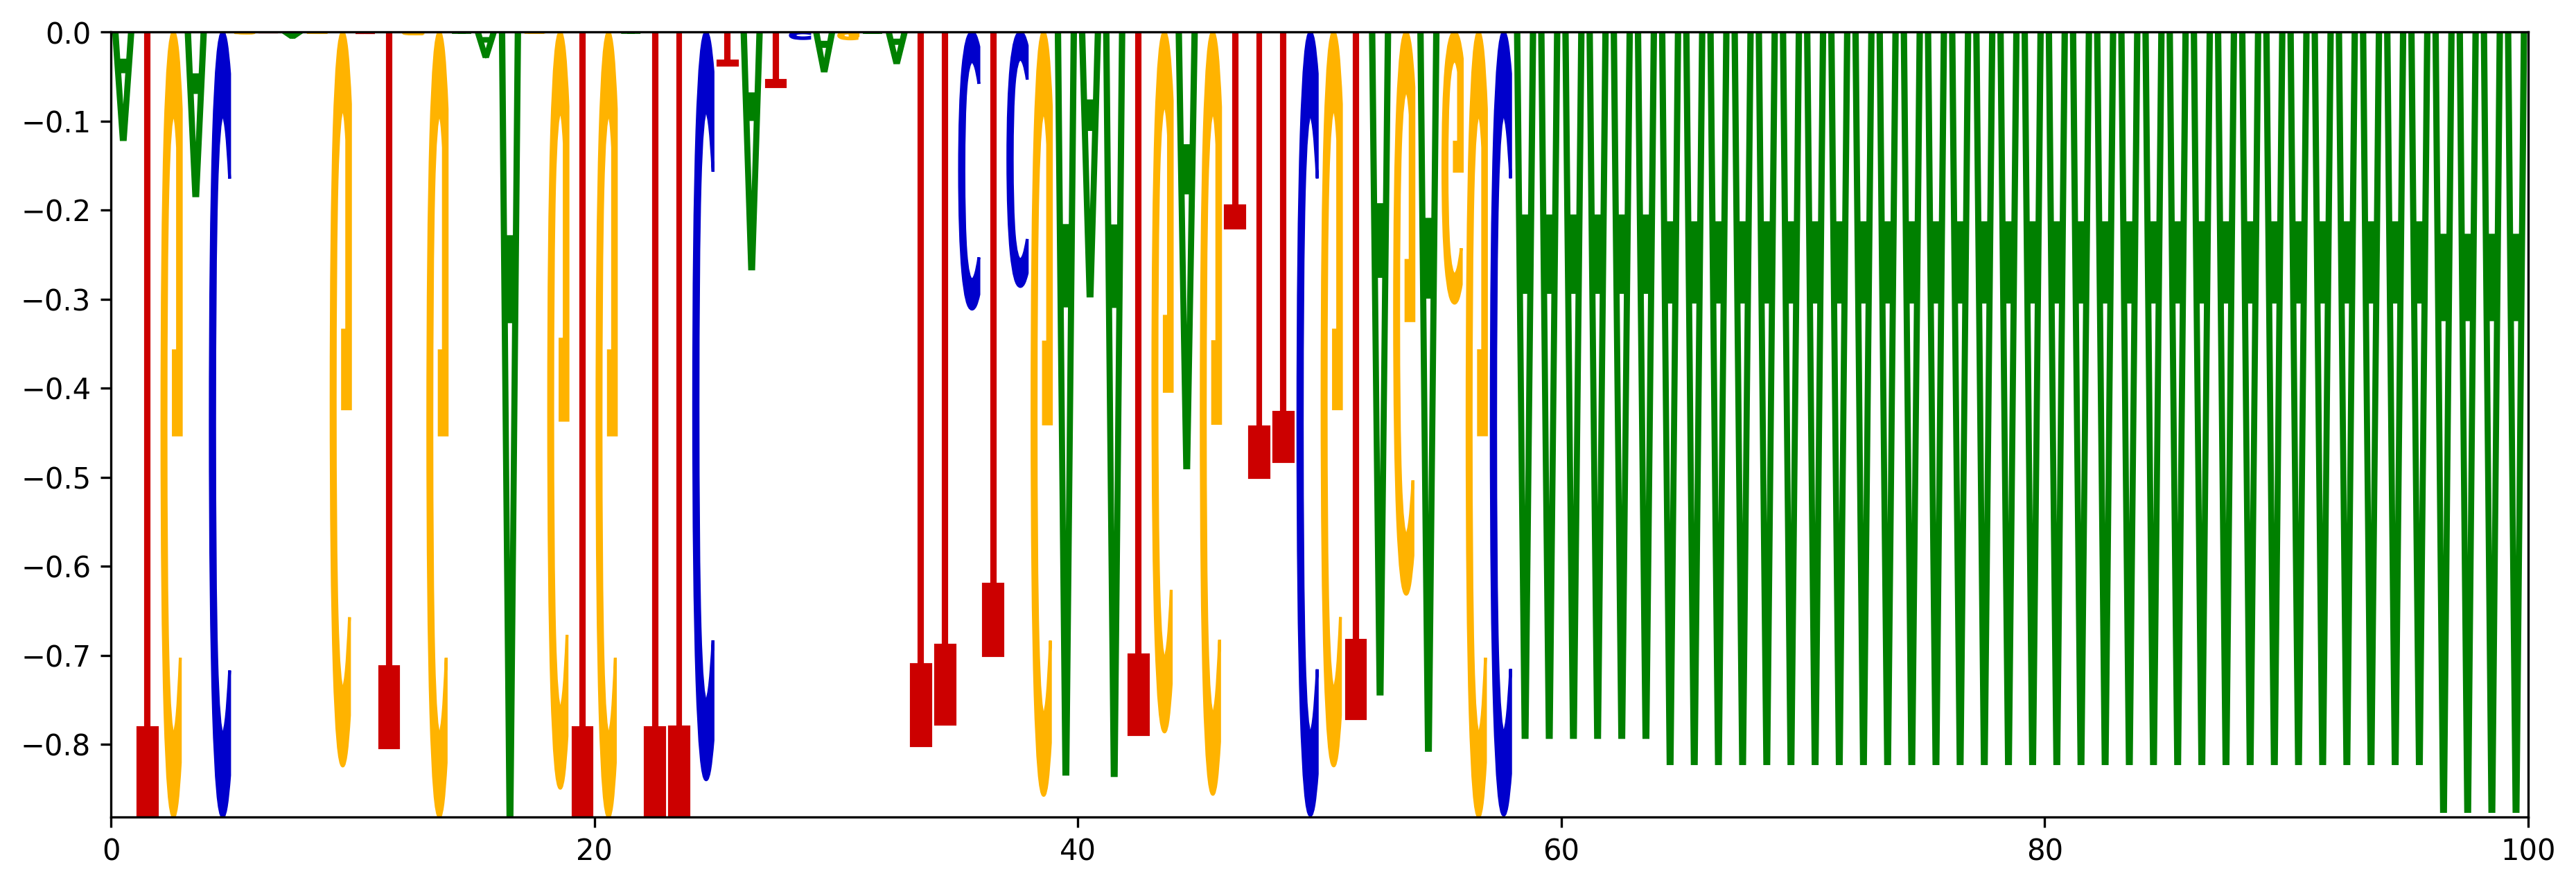

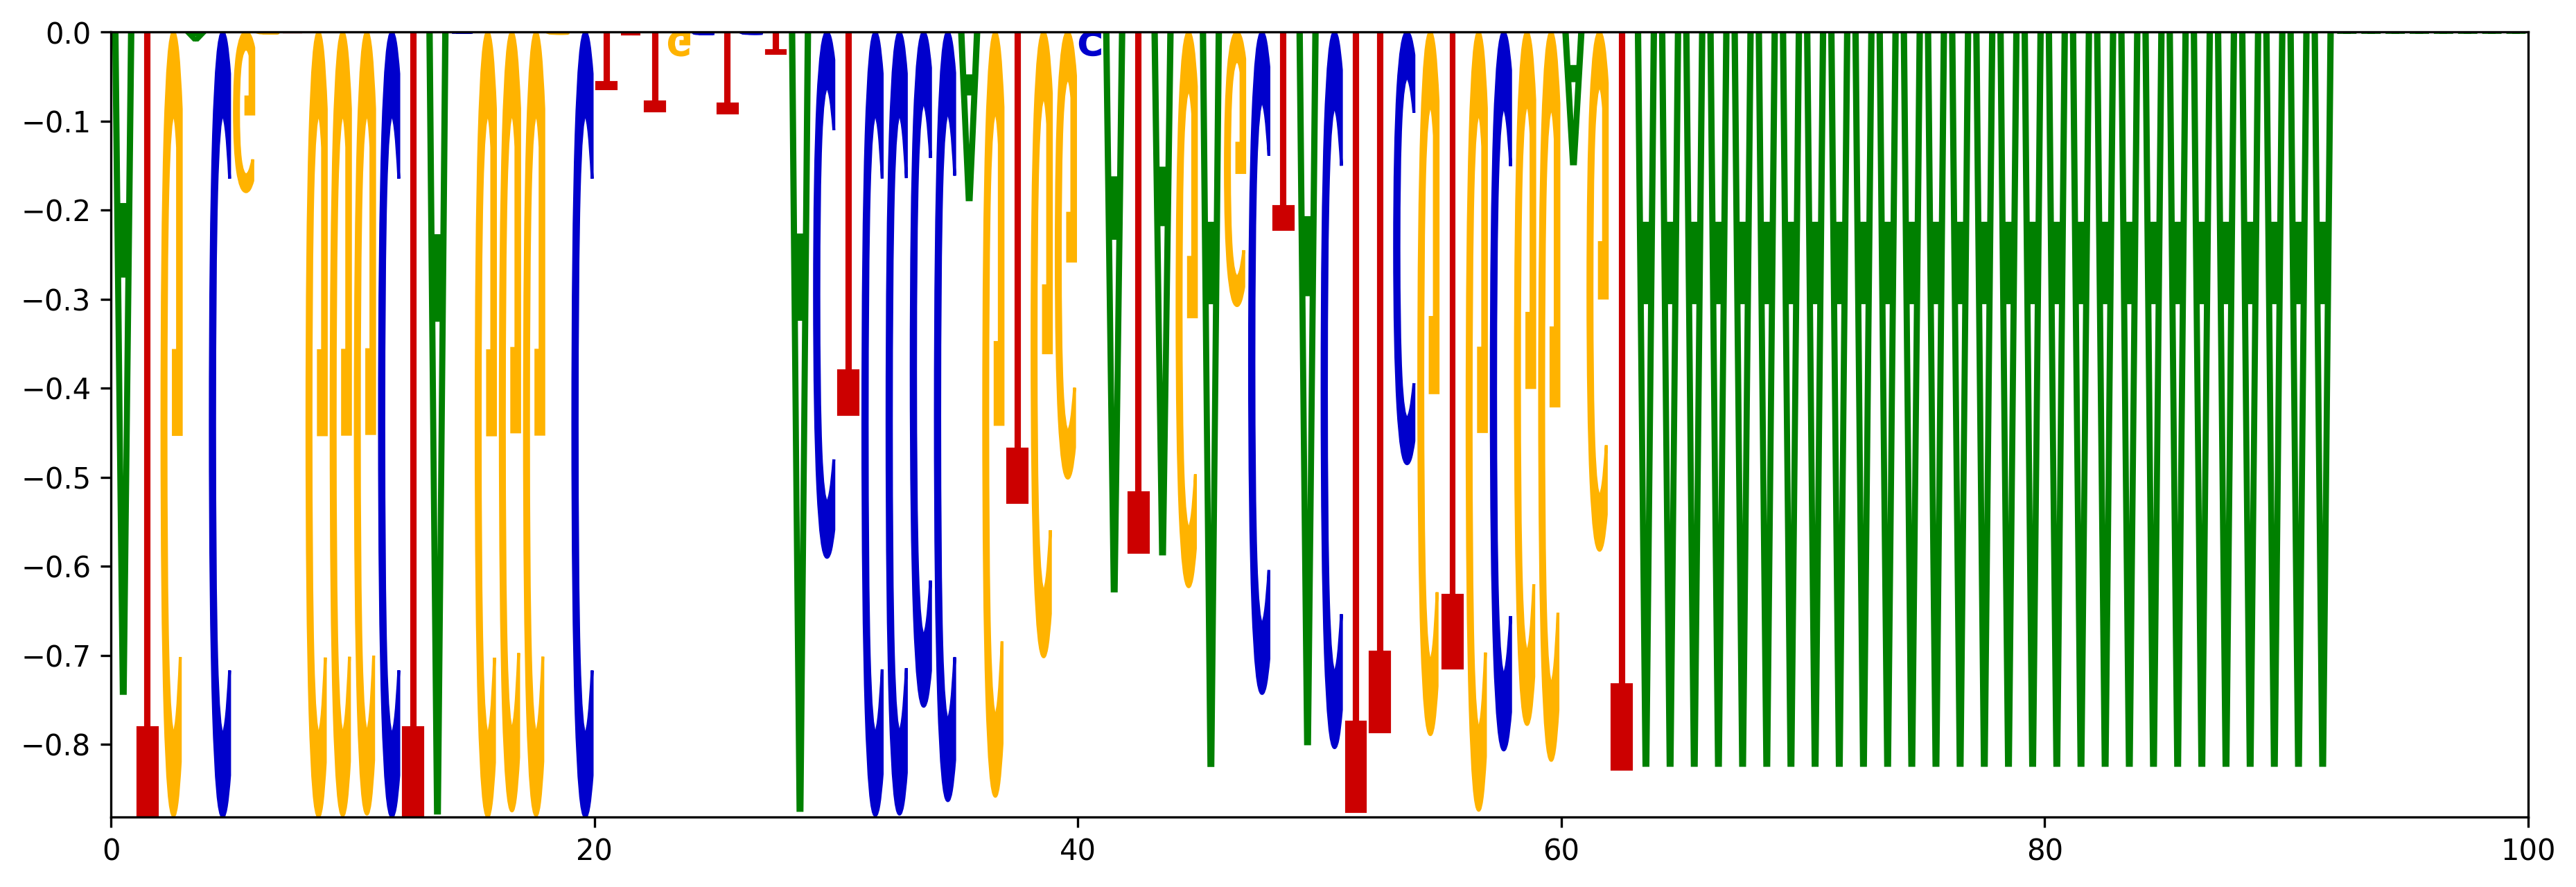

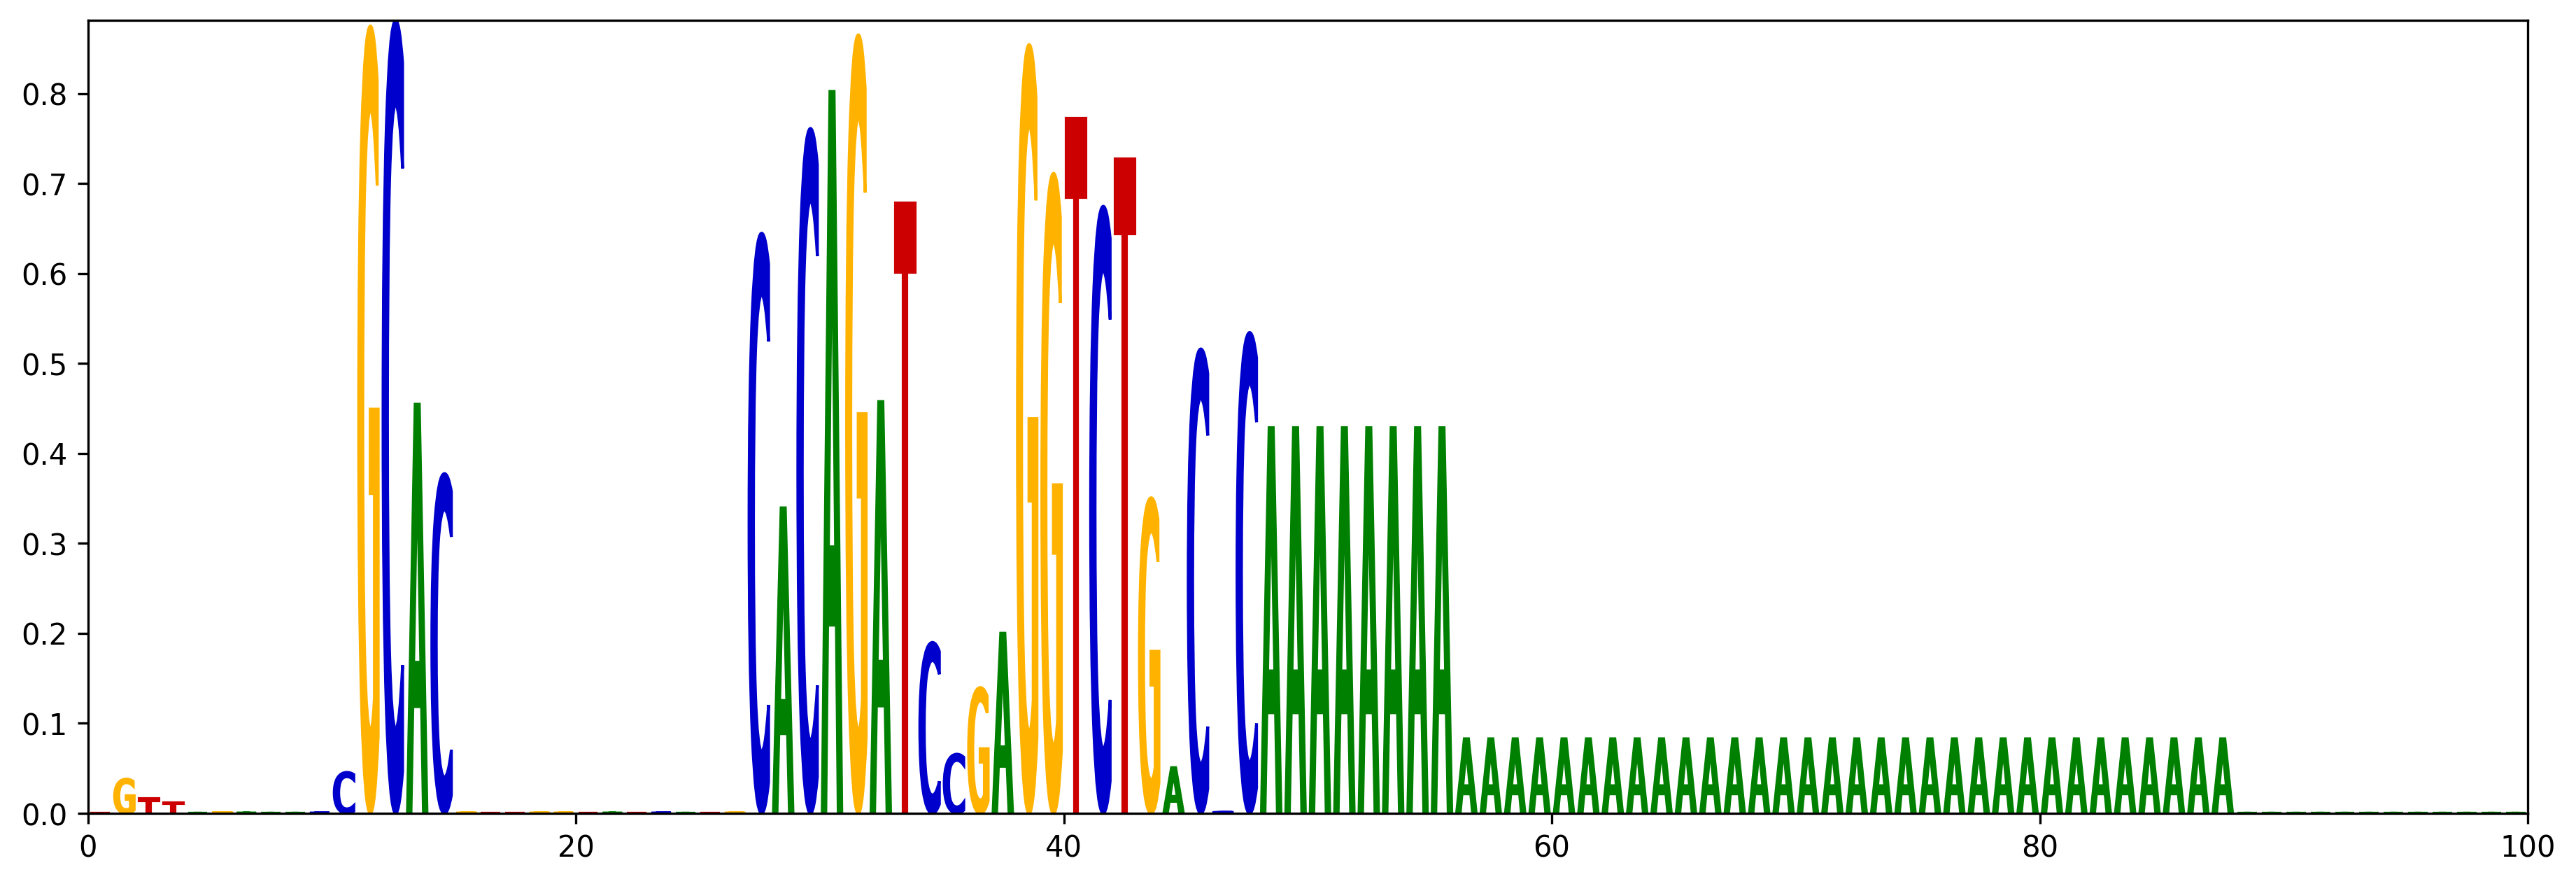

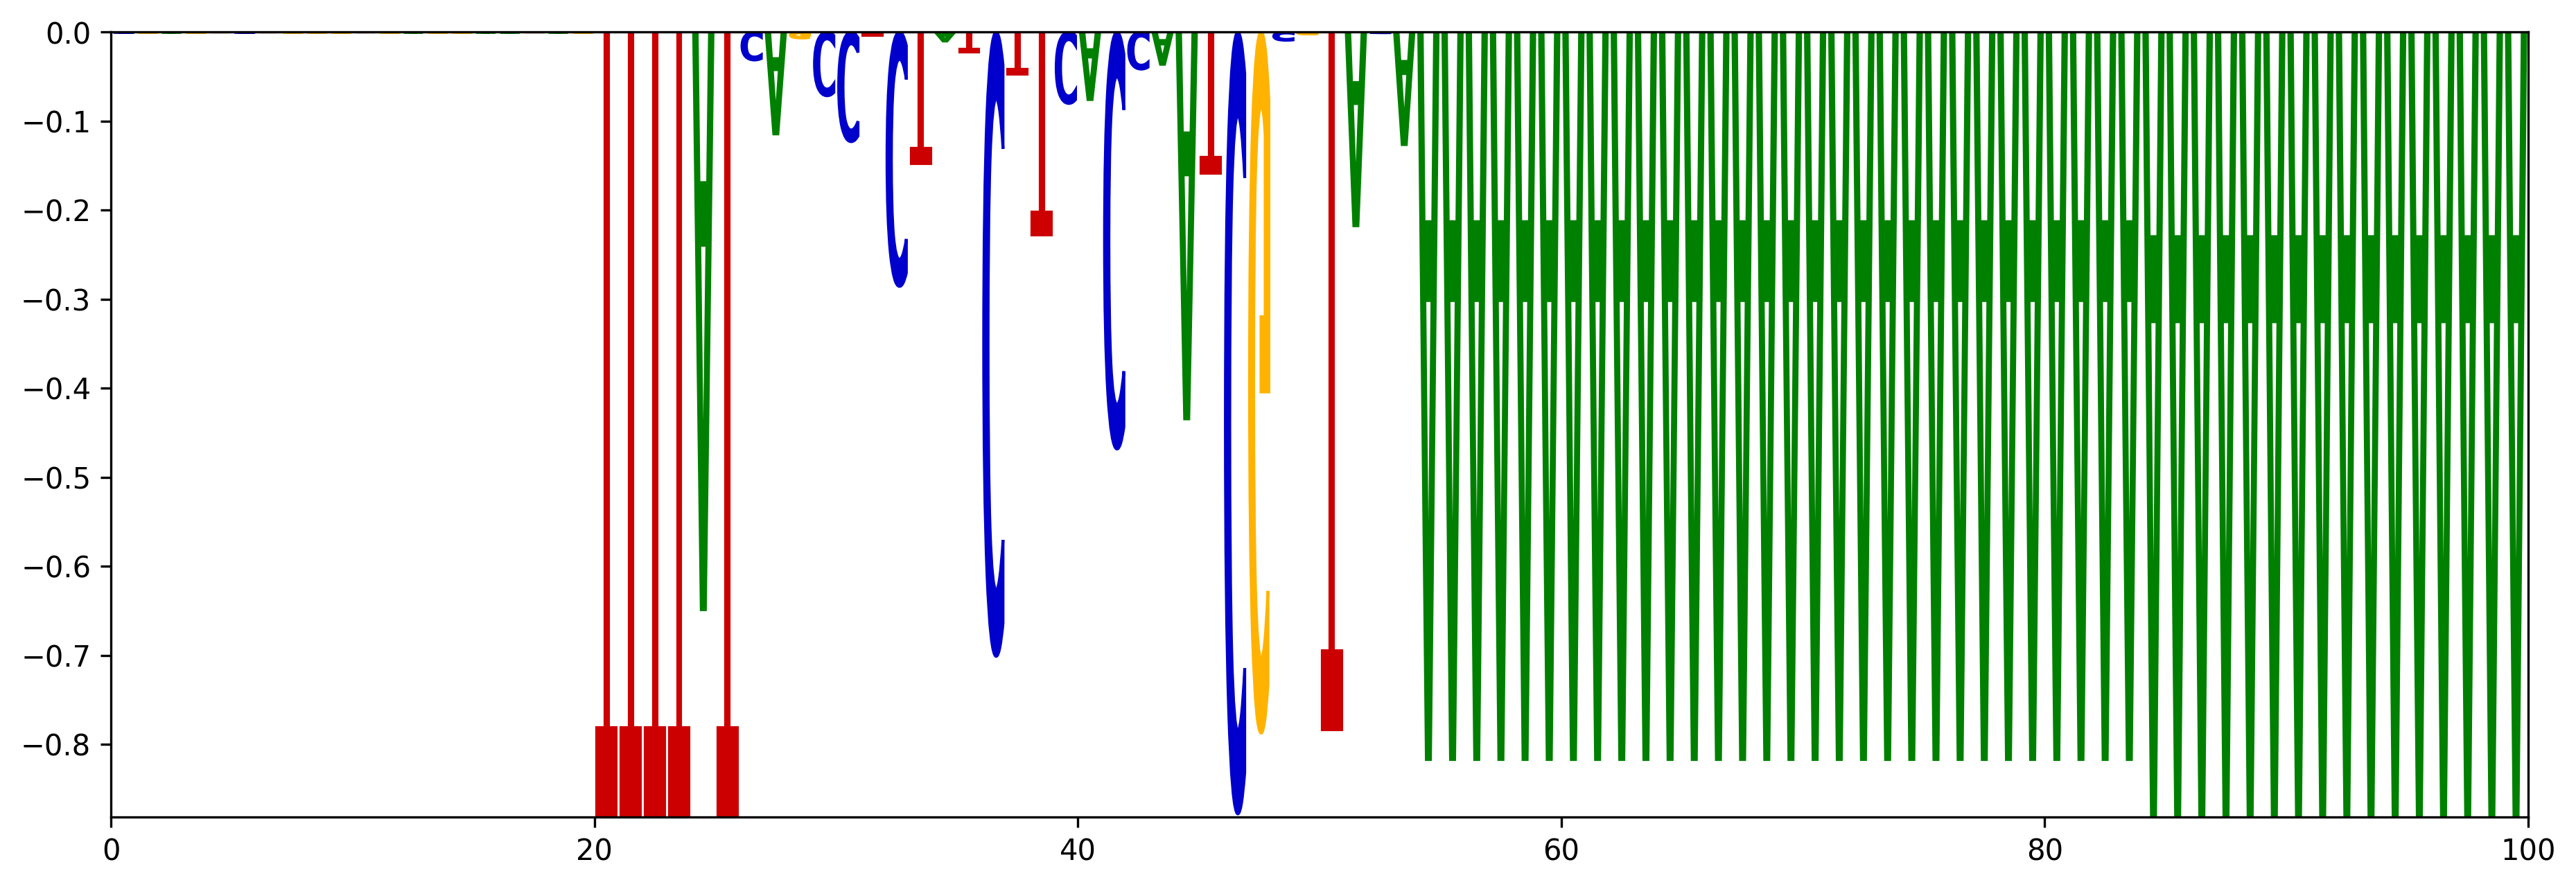

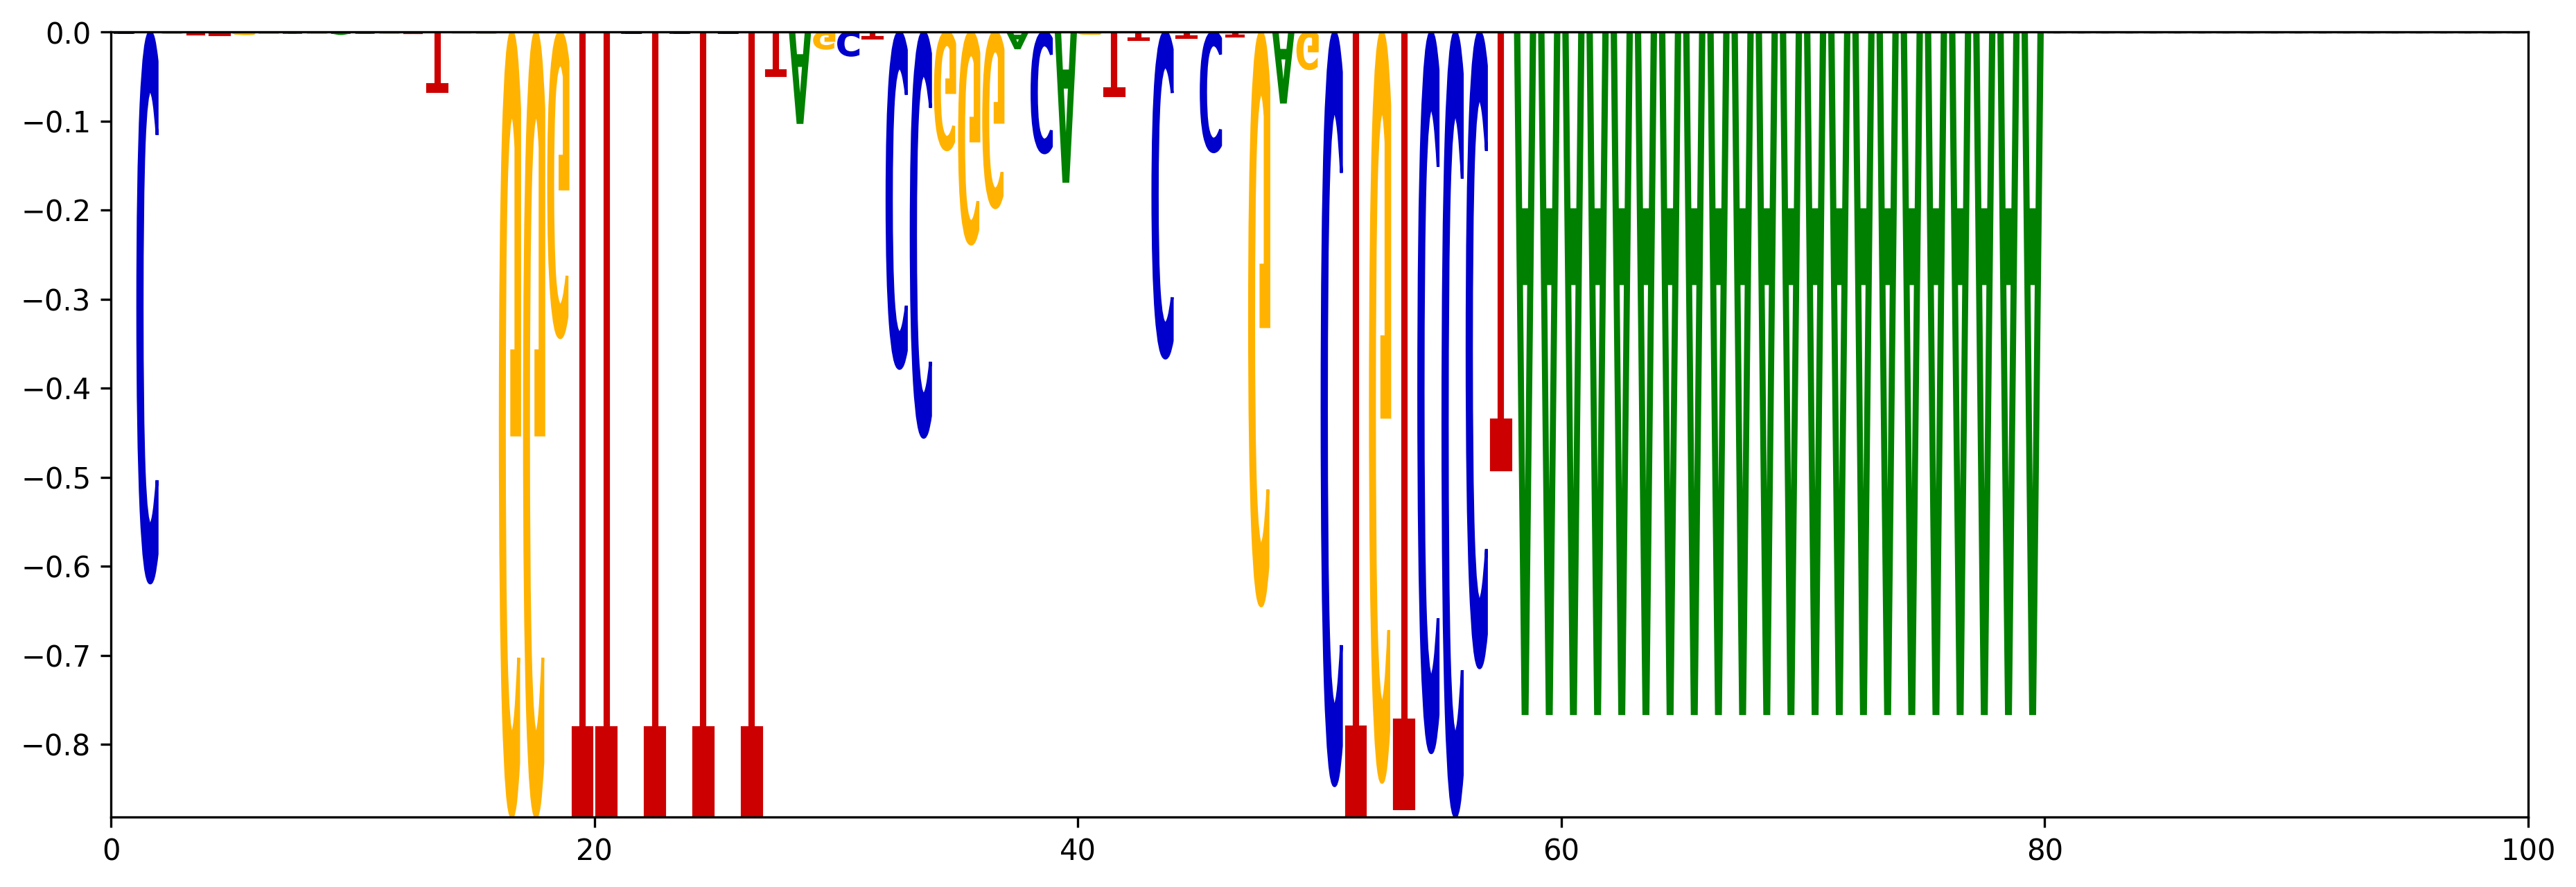

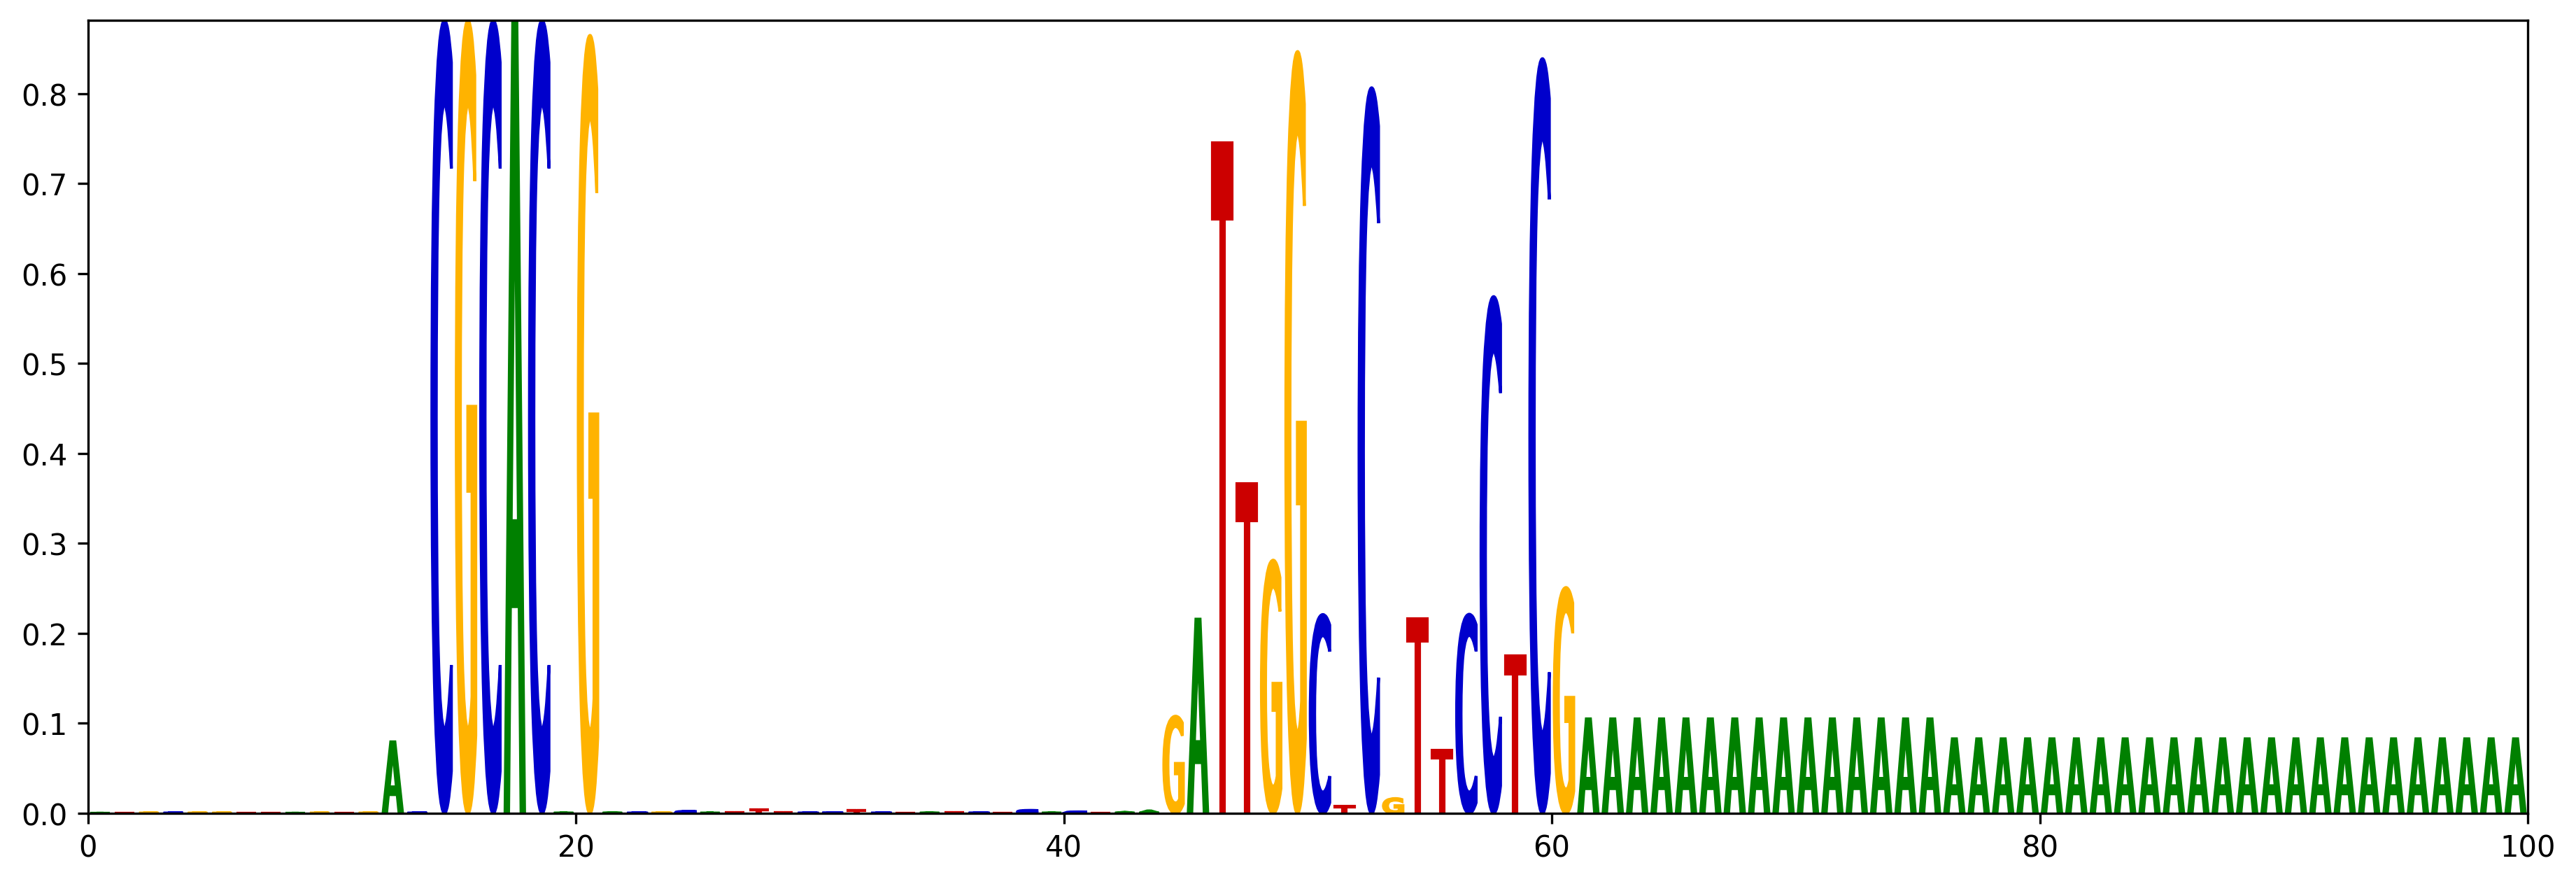

In [62]:
# Plot the 'ChIP-seq' for randomly 6 sequences for Model 2
index = np.random.randint(int(0.2*n), size=6)
sequencePlot = X_Test_2[index,:]
sequencePredict = Discriminator_Model_2.predict(sequencePlot).flatten()

# Generate a new set of X, where for each sequence every nucleotide is consecutively set to 0
sequencePlot = sequencePlot.reshape(sequencePlot.shape[0],sequencePlot.shape[1],sequencePlot.shape[2],1)
sequenceRepeat = np.repeat(sequencePlot, 100, axis=0)
# Generate sequence with one deleted nucleotide
a = np.ones((100, 100), int)
np.fill_diagonal(a, 0)
b = np.repeat(a.reshape((1,100,100)), sequencePlot.shape[0], axis=0)
c = np.concatenate(b, axis=0)
d = np.multiply(sequenceRepeat, np.repeat(c.reshape((sequenceRepeat.shape[0], 100, 1, 1)), 4, axis=2))

#Calculate the prediction for each sequence with one deleted nucleotide
d_pred = Discriminator_Model_2.predict(d.reshape(600, 100, 4)).flatten()

# Score: Difference between prediction and d_pred
scores = np.reshape((np.repeat(sequencePredict, 100) - d_pred), (len(index),100))
import sys
import os
sys.path.append('/content/gdrive/My Drive')
import motif_plotter
import matplotlib.pyplot as plt

for i in range(len(index)):
    fig=plt.figure(figsize=(15, 5), dpi= 300)
    ax=fig.add_subplot(111)
    motif_plotter.make_single_sequence_spectrum(ax, 
                                                sequencePlot[i].reshape((100, 4)),
                                                np.arcsinh(scores[i]).reshape(100,1))
    plt.show()